In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
import pandas as pd
import matplotlib.pyplot as plt
import anndata
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ensure root directory of the project
import os
if not os.getcwd().endswith('perturbations'):
    os.chdir('/home/fvk220/fvk220/sc-perturbations')

# load custom classes and functions
from _models import NBVAE
import _utils
from _utils import set_all_seeds, truncate_colormap, set_plt_layout, take_cmap_colors
from _utils import load_model, save_model, evaluate_dataset
from _training import train_nbvae
set_all_seeds(0)
set_plt_layout()


class RNA(Dataset):
    def __init__(self, data_file, subset=None):
        # load the scRNA-seq data from the specified file
        self.data = anndata.read_h5ad(data_file)
        self.data = self.data[subset] if subset is not None else self.data
        self.genes = self.data.var_names.values
        self.cells = self.data.obs_names.values
        self.obs = self.data.obs
        self.data = torch.from_numpy(
             self.data.X.toarray())
        print(self.data.shape)

        # scale cell counts by their mean
        self.data_mean = torch.mean(self.data, dim=-1, keepdim=True)
        self.normalized_data = self.data / self.data_mean
        self.log_data = torch.log1p(self.normalized_data)

        print("Before norm:", torch.min(self.data), torch.max(self.data))
        print("After norm:", torch.min(self.normalized_data), torch.max(self.normalized_data))
        print("Log data:", torch.min(self.log_data), torch.max(self.log_data))


    def __len__(self):
        # return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, index):
        # return the preprocessed data for the specified example
        return index, self.data[index], self.data_mean[index], self.normalized_data[index], self.log_data[index]
    

dev = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
bs = 2**9
train_pct = 0.82; val_pct = 0.09; test_pct = 0.09

# identify KO and WT indices
full_dataset = RNA("data/mousebrain/anndata_hvg.h5ad")
wt_indices = np.where(full_dataset.obs["genotype"] == "WT")[0]
ko_indices = np.where(full_dataset.obs["genotype"] == "KO")[0]

# create new dataset
keep_proportion = 0.1
np.random.shuffle(ko_indices)
subset_ko_length = int(keep_proportion * len(ko_indices))
subset_ko_indices = ko_indices[:subset_ko_length]
subset = np.concatenate([wt_indices, subset_ko_indices])
full_dataset_10 = RNA("data/mousebrain/anndata_hvg.h5ad", subset=subset)

# Split into train, validation, and test subsets
indices = np.arange(len(full_dataset_10))
np.random.shuffle(indices)

train_end = int(len(full_dataset_10) * train_pct)
val_end = int(len(full_dataset_10) * train_pct + len(full_dataset_10) * val_pct)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

# Define a function to generate subset data loader
def get_subset_loader(dataset, indices):
    subset = torch.utils.data.Subset(dataset, indices)
    return DataLoader(subset, batch_size=bs, shuffle=True)

# Create the data loaders
train_loader = get_subset_loader(full_dataset_10, train_indices)
val_loader = get_subset_loader(full_dataset_10, val_indices)
test_loader = get_subset_loader(full_dataset_10, test_indices)


print("Sizes:", len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

2025-02-24 18:21:37.258797: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 18:21:37.280028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 18:21:37.304213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 18:21:37.311886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 18:21:37.337870: I tensorflow/core/platform/cpu_feature_guar

torch.Size([13931, 3451])
Before norm: tensor(0.) tensor(3965.)
After norm: tensor(0.) tensor(2842.8416)
Log data: tensor(0.) tensor(7.9529)
torch.Size([8783, 3451])
Before norm: tensor(0.) tensor(2596.)
After norm: tensor(0.) tensor(2842.8416)
Log data: tensor(0.) tensor(7.9529)
Sizes: 7202 790 791


In [3]:
# TRAIN SINGLE MODEL
model_params = {"input_dim": len(full_dataset.data[0]), "latent_dim": 2, "scaling_type": "mean"}
vae = NBVAE(**model_params).to(dev)
vae_opt = optim.Adam(vae.parameters(), lr=1.2e-3)
vae.train()
vae, vae_loss_hist = train_nbvae(vae, vae_opt, train_loader, val_loader, 1000, beta=50, warmup_epochs=10, patience=10, dev=dev)

Epochs:  10%| | 98/1000 [00:26<04:00,  3.75it/s, Loss=1120.2203, Recon=1078.8413, KL=0.8276, Val=1128.6097, Best=1124

Early stopping
Best epoch: 88 val loss: 1124.1925632911393


best k: 4 ari: 0.8073221649483465
ari: 0.8073
rmse: 0.1805 mae: 0.2154
gene indices: [1717, 1981, 2238, 2631, 2848, 3180, 3290]
                                   x         y
genotype cell_type                            
KO       Irf8 KO CP-BAM     0.885104  0.015247
         Irf8 KO microglia  0.386650  0.006462
         WT CP-BAM               NaN       NaN
         WT microglia            NaN       NaN
WT       Irf8 KO CP-BAM          NaN       NaN
         Irf8 KO microglia       NaN       NaN
         WT CP-BAM          1.106922  0.003636
         WT microglia      -0.700460  0.005328


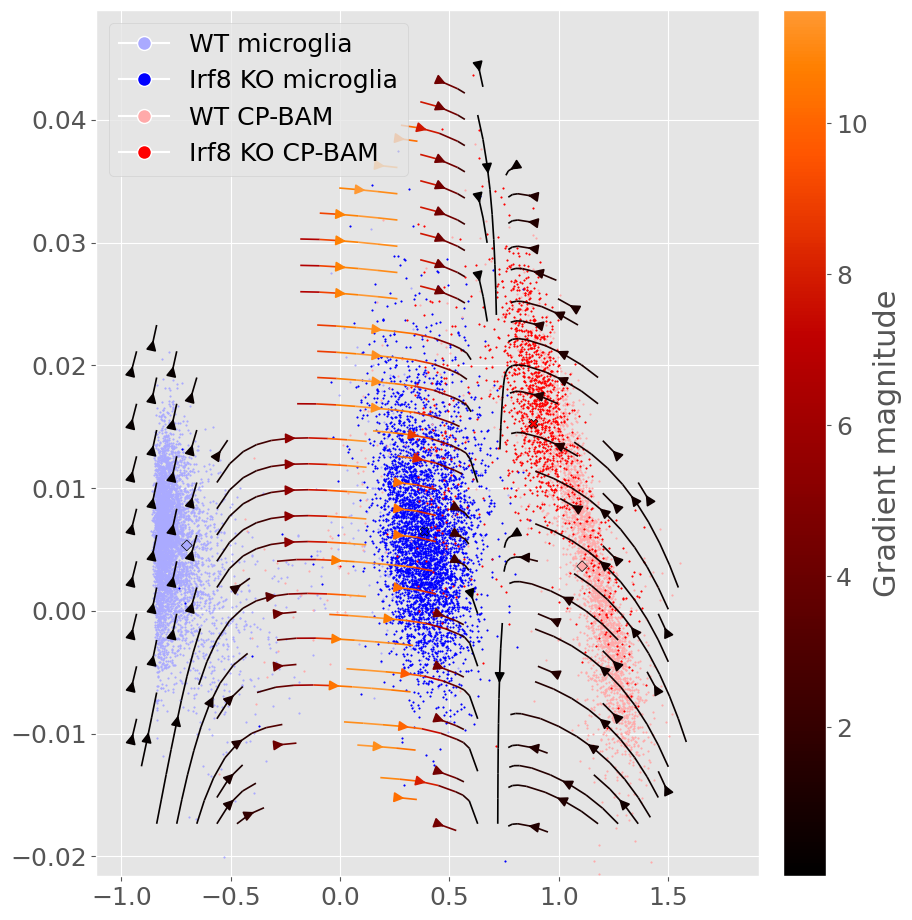

In [4]:
from scipy.ndimage import binary_dilation, binary_erosion, binary_closing

# use full dataset 
x_hat, mu, metrics = evaluate_dataset(full_dataset.data, full_dataset.log_data, full_dataset.data_mean,
      vae, "mousebrain", compute_ari=True, ari_ks=np.arange(2,5,1), obs=full_dataset.obs)
metrics = pd.DataFrame([metrics])

boundaries = 1.3 * np.quantile(mu, [0.001, 0.999], axis=0)  #np.array([np.min(vae_latent, axis=0), np.max(vae_latent, axis=0)])
x_min, y_min = boundaries[0]
x_max, y_max = boundaries[1]
rectangle = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]])

# create a grid in the boundary region
grid_size = 40
x_grid = np.linspace(x_min, x_max, grid_size)
y_grid = np.linspace(y_min, y_max, grid_size)
x1, x2 = np.meshgrid(x_grid, y_grid)

# flatten grid to list of (x1, x2) pairs
flat = np.vstack([x1.flatten(), x2.flatten()]).T

# select gene or subset of genes
# gene_subset = ["Irf8"] 
gene_subset = ['Ly86', 'Marcks', 'Ctsh', 'Aif1', 'Ckb', 'Bin1', 'Irf8'] # found to be coregulated
gene_idx = [i for i, g in enumerate(full_dataset.genes) if g in gene_subset]
# gene_idx = [np.random.randint(0, len(full_dataset.genes), size=1)[0]] # random gene
print("gene indices:", gene_idx)

# compute gradients and unflatten
J = -vae.grad_wrt_i(torch.tensor(flat).to(dev).float(), gene_idx).detach().cpu().numpy()
# J = J / np.linalg.norm(J, axis=2).reshape(-1,len(gene_idx),1) # unit norm
J = J.mean(axis=1)

xx = J[:,0].reshape(len(x_grid), len(x_grid))
yy = J[:,1].reshape(len(y_grid), len(y_grid))
magnitude = np.sqrt(xx**2 + yy**2)

# mask out the region outside points
hist, _, _ = np.histogram2d(mu[:, 0].numpy(), mu[:, 1].numpy(), bins=[x_grid, y_grid])
mask = hist.T > 0
mask_padded = np.pad(mask, ((0, 1), (0, 1)), mode='constant')
mask_dilated = binary_dilation(mask_padded, iterations=2)
mask_dilated = binary_closing(mask_dilated, iterations=2)
# mask_dilated = binary_dilation(mask_dilated, iterations=2)

xx = np.where(mask_dilated, xx, np.nan)
yy = np.where(mask_dilated, yy, np.nan)


set_plt_layout()

# labels
obs = full_dataset.obs.copy()
c = obs.cell_type
discrete_colors = dict( zip( c, c.cat.codes) )

# mean of each cell type
obs[["x", "y"]] = mu
cell_type_means = obs.groupby(["genotype", "cell_type"])[["x", "y"]].mean()
print(cell_type_means)

# colors
cmap_colors = take_cmap_colors(truncate_colormap("bwr", 0, 1), 4)
adjusted_cmap_colors = [cmap_colors[1], cmap_colors[0], cmap_colors[2], cmap_colors[3]]
cell_types = c.value_counts().index.astype("str").values
cell_type_to_color = {cell_type: color for cell_type, color in zip(cell_types, adjusted_cmap_colors)}


# plotting ----------
fig, ax = plt.subplots(1, 1, figsize=(9,9))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# scatter
for cell_type in cell_types:
    mask = full_dataset.obs['cell_type'].values == cell_type
    plt.scatter(mu[mask,0], mu[mask,1], c=[cell_type_to_color[cell_type]], s=1, label=cell_type)
scatters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in cell_type_to_color.values()]
plt.legend(scatters, cell_types, loc="upper left")# title="Cell type")

# streamplot
stream = plt.streamplot(x1, x2, xx, yy, linewidth=1.2, color=magnitude, cmap=truncate_colormap("gist_heat", 0, 0.8),
     density=(1.15, 1.15), minlength=0.02, maxlength=0.5, arrowstyle='-|>', arrowsize=1.5)
cbar = fig.colorbar(stream.lines, ax=ax, pad=0.03, shrink=1, aspect=20, label="Gradient magnitude")

hifplus = cell_type_means.loc['WT'].dropna()
hifminus = cell_type_means.loc['KO'].dropna()
plt.scatter(hifplus["x"], hifplus["y"], s=30, c=hifplus.index.astype("str").map(cell_type_to_color), marker="D", edgecolors="black", zorder=np.inf)
plt.scatter(hifminus["x"], hifminus["y"], s=40, c=hifminus.index.astype("str").map(cell_type_to_color), marker="X", edgecolors="black", zorder=np.inf)
plt.tight_layout(pad=0)
# plt.savefig(f"data/mousebrain_10pct_nbvae.png", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# model_params = {"input_dim": len(full_dataset.data[0]), "latent_dim": 2, "scaling_type": "mean"}
# save_model(vae, vae_opt, vae_loss_hist, model_params, 'mousebrain0.68ari_0.25mae')

# p = "checkpoints/mousebrain_0.73ari_0.24mae_20250220_153934.pt"
# vae, _, _, model_params = load_model(p, model_type='nbvae', dev=dev)

In [6]:
# TRAIN N_ITER MODELS
compute_ari = True
n_iter = 5

train_results = []
test_results = []
for i in range(n_iter):
    # init model and train
    model_params = {"input_dim": next(iter(train_loader))[1].shape[-1], "latent_dim": 2, "scaling_type": "mean"}
    vae = NBVAE(**model_params).to(dev)
    vae_opt = optim.Adam(vae.parameters(), lr=1.2e-3)
    vae, vae_loss_hist = train_nbvae(vae, vae_opt, train_loader, val_loader, 1000, beta=50, warmup_epochs=10, patience=10, dev=dev)
    vae.eval()

    print("\nTRAIN METRICS-------")
    _, _, train_metrics = evaluate_dataset(full_dataset.data[train_indices], full_dataset.log_data[train_indices], 
                                           full_dataset.data_mean[train_indices], vae, "mousebrain", compute_ari, 
                                           obs=full_dataset.obs.iloc[train_indices])
    print("\nTEST METRICS-------")
    _, _, test_metrics  = evaluate_dataset(full_dataset.data[test_indices], full_dataset.log_data[test_indices],
                                           full_dataset.data_mean[test_indices], vae, "mousebrain", compute_ari,
                                           obs=full_dataset.obs.iloc[test_indices])

    # append to lists with extra n_iter column
    train_results.append({'n_iter': i, **train_metrics})
    test_results.append({'n_iter': i, **test_metrics})

# convert to dataframe
train_df = pd.DataFrame(train_results)
test_df = pd.DataFrame(test_results)

# write dataframes with tamestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
train_df.to_csv(f"data/cko_train_{timestamp}.csv")
test_df.to_csv(f"data/cko_test_{timestamp}.csv")

# Calculate mean and standard deviation for train metrics
train_mean = train_df.drop(columns=["n_iter"]).mean()
train_std = train_df.drop(columns=["n_iter"]).std()
test_mean = test_df.drop(columns=["n_iter"]).mean()
test_std = test_df.drop(columns=["n_iter"]).std()

# Print the results
print("\nTRAIN STATISTICS--------")
for metric in train_mean.index:
    print(f"Mean {metric:>8}: ${train_mean[metric]:.3f} \pm {train_std[metric]:.3f}$")

print("\nTEST STATISTICS--------")
for metric in test_mean.index:
    print(f"Mean {metric:>8}: ${test_mean[metric]:.3f} \pm {test_std[metric]:.3f}$")

Epochs:  11%| | 111/1000 [00:31<04:13,  3.51it/s, Loss=1117.0449, Recon=1076.3298, KL=0.8143, Val=1125.5588, Best=112

Early stopping
Best epoch: 101 val loss: 1122.4221914556963

TRAIN METRICS-------


best k: 3 ari: 0.7201355291791075
ari: 0.7201
rmse: 0.1918 mae: 0.2277

TEST METRICS-------
best k: 3 ari: 0.7551888158251101
ari: 0.7552
rmse: 0.1922 mae: 0.2281


Epochs:  12%| | 121/1000 [00:31<03:51,  3.79it/s, Loss=1116.1705, Recon=1075.0218, KL=0.8230, Val=1123.7568, Best=112

Early stopping
Best epoch: 111 val loss: 1120.7100474683543

TRAIN METRICS-------


best k: 3 ari: 0.6953461862022884
ari: 0.6953
rmse: 0.1926 mae: 0.2283

TEST METRICS-------
best k: 3 ari: 0.7096892567566093
ari: 0.7097
rmse: 0.1929 mae: 0.2287


Epochs:   9%| | 88/1000 [00:22<03:53,  3.91it/s, Loss=1119.2785, Recon=1078.8261, KL=0.8090, Val=1126.9662, Best=1126

Early stopping
Best epoch: 78 val loss: 1126.571835443038

TRAIN METRICS-------


best k: 3 ari: 0.6991416657396776
ari: 0.6991
rmse: 0.1927 mae: 0.2288

TEST METRICS-------
best k: 3 ari: 0.7380772726494615
ari: 0.7381
rmse: 0.1931 mae: 0.2292


Epochs:   8%| | 77/1000 [00:19<03:55,  3.91it/s, Loss=1121.5887, Recon=1080.8239, KL=0.8153, Val=1129.1097, Best=1128

Early stopping
Best epoch: 67 val loss: 1128.6840189873417

TRAIN METRICS-------


best k: 3 ari: 0.7362713285093866
ari: 0.7363
rmse: 0.1948 mae: 0.2291

TEST METRICS-------
best k: 3 ari: 0.7508168129536965
ari: 0.7508
rmse: 0.1952 mae: 0.2291


Epochs:   9%| | 91/1000 [00:23<03:53,  3.89it/s, Loss=1119.7246, Recon=1079.1077, KL=0.8123, Val=1128.2852, Best=1126

Early stopping
Best epoch: 81 val loss: 1126.2242879746836

TRAIN METRICS-------


best k: 3 ari: 0.7395172743221204
ari: 0.7395
rmse: 0.1938 mae: 0.2286

TEST METRICS-------
best k: 3 ari: 0.7663057412268267
ari: 0.7663
rmse: 0.1946 mae: 0.2291

TRAIN STATISTICS--------
Mean     rmse: $0.193 \pm 0.001$
Mean      mae: $0.229 \pm 0.001$
Mean      ari: $0.718 \pm 0.020$

TEST STATISTICS--------
Mean     rmse: $0.194 \pm 0.001$
Mean      mae: $0.229 \pm 0.000$
Mean      ari: $0.744 \pm 0.022$


In [7]:
# # TRAIN 32-DIMENSIONAL MODEL
model_params = {"input_dim": len(full_dataset.data[0]), "latent_dim": 32, "scaling_type": "mean"}
vae_32d = NBVAE(**model_params).to(dev)
vae_opt_32d = optim.Adam(vae_32d.parameters(), lr=1.2e-3, amsgrad=True)
vae_32d.train()

vae_32d, vae_32d_loss_hist = train_nbvae(vae_32d, vae_opt_32d, train_loader, val_loader, 1000, beta=1, warmup_epochs=30, patience=15, dev=dev)

x_hat, mu, metrics = evaluate_dataset(full_dataset.data, full_dataset.log_data, full_dataset.data_mean,
      vae_32d, "mousebrain", compute_ari=True, ari_ks=np.arange(2,5,1), obs=full_dataset.obs)
metrics = pd.DataFrame([metrics])

Epochs:  16%|▏| 161/1000 [00:41<03:34,  3.91it/s, Loss=1022.8331, Recon=1016.1206, KL=6.7124, Val=1048.7906, Best=104

Early stopping
Best epoch: 146 val loss: 1048.203125


best k: 4 ari: 0.5702432851146927
ari: 0.5702
rmse: 0.1496 mae: 0.1969


In [8]:
# subsample WT
z = mu[np.where(full_dataset.obs["genotype"]=="WT")[0]]
z = z[np.random.choice(len(z), size=int(len(z)/64), replace=False)]

gene_subset = ['Ly86', 'Marcks', 'Ctsh', 'Aif1', 'Ckb', 'Bin1', 'Irf8']
gene_idx = [i for i, g in enumerate(full_dataset.genes) if g in gene_subset]
print("gene indices:", gene_idx)

# one gradient step
z = mu[np.random.choice(len(mu), size=int(len(mu)/64), replace=False)]
J = -vae_32d.grad_wrt_i(torch.tensor(z).to(dev).float(), gene_idx).detach().cpu().numpy()
J = J.mean(axis=1) * 0.005
z2 = z + J

# 400 gradient steps 
zn = torch.tensor(z).to(dev).float()
with torch.no_grad():
    nsteps = 500
    for i in range(nsteps):
        zn = vae_32d.make_step(zn, gene_idx, delta=0.001, )
        if i%50 == 0:
            print(i)
    zn = zn.detach().cpu().numpy()

gene indices: [1717, 1981, 2238, 2631, 2848, 3180, 3290]
0


/tmp/ipykernel_924855/2227413829.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  J = -vae_32d.grad_wrt_i(torch.tensor(z).to(dev).float(), gene_idx).detach().cpu().numpy()
/tmp/ipykernel_924855/2227413829.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zn = torch.tensor(z).to(dev).float()


50
100
150
200
250
300
350
400
450


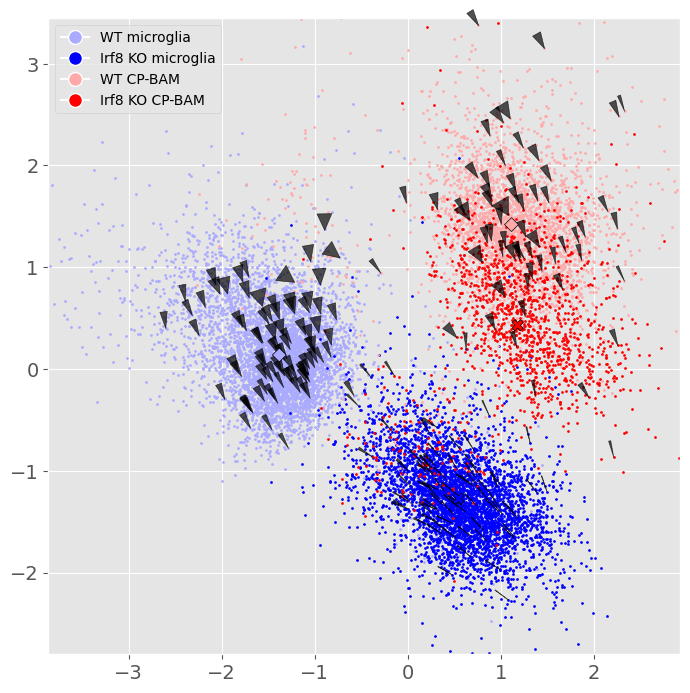

In [9]:
from sklearn.decomposition import PCA

# perform PCA
pca = PCA(n_components=2)
mu_pca = pca.fit_transform(mu)
z_pca = pca.transform(z)
z2_pca = pca.transform(z2)

# prepare data and colors
set_plt_layout()
obs = full_dataset.obs.copy()
c = obs.cell_type
discrete_colors = dict( zip( c, c.cat.codes) )
obs[["x", "y"]] = mu_pca
cell_type_means = obs.groupby(["genotype", "cell_type"])["x","y"].mean()

cmap_colors = take_cmap_colors(truncate_colormap("bwr", 0, 1), 4)
adjusted_cmap_colors = [cmap_colors[1], cmap_colors[0], cmap_colors[2], cmap_colors[3]]

cell_types = c.value_counts().index.astype("str").values
cell_type_to_color = {cell_type: color for cell_type, color in zip(cell_types, adjusted_cmap_colors)}

# plotting
fig, ax = plt.subplots(1,1, figsize=(7,7))
for cell_type in cell_types:
    mask = full_dataset.obs['cell_type'].values == cell_type
    plt.scatter(mu_pca[mask,0], mu_pca[mask,1], c=[cell_type_to_color[cell_type]], s=2, label=cell_type)
scatters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in cell_type_to_color.values()]
plt.legend(scatters, cell_types)

# arrows
mags = np.linalg.norm(z2_pca - z_pca, axis=1)
for i in range(z_pca.shape[0]):
    w = mags[i] * 400 #200 #30000
    ax.annotate(text='', xy=(z2_pca[i,0], z2_pca[i,1]), xytext=(z_pca[i,0],z_pca[i,1]), arrowprops=dict(color="k", alpha=0.68, headwidth=2*w, width=w,))

plt.xlim(1.01*np.percentile(mu_pca[:,0], 0.1), 1.01*np.percentile(mu_pca[:,0], 99.9))
plt.ylim(1.01*np.percentile(mu_pca[:,1], 0.1), 1.01*np.percentile(mu_pca[:,1], 99.9))
plt.xlabel("") # latent z₁
plt.ylabel("") # latent z₂
ax.tick_params(axis='both', which='major', labelsize=14)

# cell type centers
hifplus = cell_type_means.loc['WT'].dropna()
hifminus = cell_type_means.loc['KO'].dropna()
plt.scatter(hifplus["x"], hifplus["y"], s=50, c=hifplus.index.astype("str").map(cell_type_to_color), marker="D", edgecolors="black", zorder=np.inf)
plt.scatter(hifminus["x"], hifminus["y"], s=65, c=hifminus.index.astype("str").map(cell_type_to_color), marker="X", edgecolors="black", zorder=np.inf)
plt.tight_layout()
# plt.savefig(f"data/cko_32d_pca_0border.png")
plt.show()

In [10]:
import umap

umap = umap.UMAP(n_components=2, min_dist=0.999)

# concatenate mu, z and z2
mu_all = np.concatenate([mu, z, z2], axis=0)
mu_all_umap = umap.fit_transform(mu_all)

# extract mu, z and z2
mu_umap = mu_all_umap[:len(mu)]
z_umap  = mu_all_umap[len(mu):len(mu)+len(z)]
z2_umap = mu_all_umap[len(mu)+len(z):]

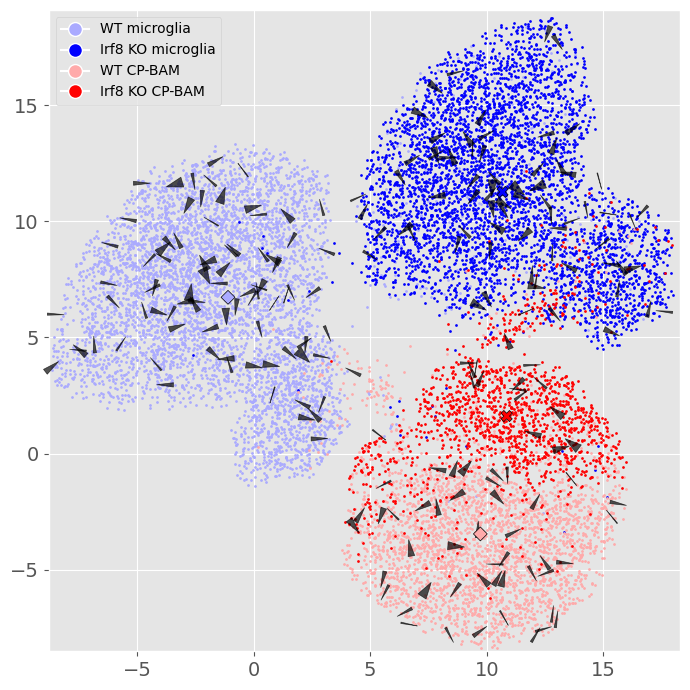

In [11]:
# prepare data and colors
obs = full_dataset.obs.copy()
c = obs.cell_type
discrete_colors = dict( zip( c, c.cat.codes) )
obs[["x", "y"]] = mu_umap
cell_type_means = obs.groupby(["genotype", "cell_type"])[["x","y"]].mean()

cmap_colors = take_cmap_colors(truncate_colormap("bwr", 0, 1), 4)
adjusted_cmap_colors = [cmap_colors[1], cmap_colors[0], cmap_colors[2], cmap_colors[3]]

cell_types = c.value_counts().index.astype("str").values
cell_type_to_color = {cell_type: color for cell_type, color in zip(cell_types, adjusted_cmap_colors)}

# plotting
fig, ax = plt.subplots(1,1, figsize=(7,7))
for cell_type in cell_types:
    mask = full_dataset.obs['cell_type'].values == cell_type
    plt.scatter(mu_umap[mask,0], mu_umap[mask,1], c=[cell_type_to_color[cell_type]], s=2, label=cell_type)
scatters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in cell_type_to_color.values()]
plt.legend(scatters, cell_types)

# arrows
mags = np.linalg.norm(z2_umap - z_umap, axis=1)
for i in range(z_pca.shape[0]):
    w = mags[i] * 6
    ax.annotate(text='', xy=(z2_umap[i,0], z2_umap[i,1]), xytext=(z_umap[i,0],z_umap[i,1]), arrowprops=dict(color="k", alpha=0.68, headwidth=2*w, width=w,))

plt.xlim(1.02*np.percentile(mu_umap[:,0], 0.01), 1.02*np.percentile(mu_umap[:,0], 99.99))
plt.ylim(1.02*np.percentile(mu_umap[:,1], 0.01), 1.02*np.percentile(mu_umap[:,1], 99.99))
plt.xlabel("") # latent z₁
plt.ylabel("") # latent z₂
ax.tick_params(axis='both', which='major', labelsize=14)

hifplus = cell_type_means.loc['WT'].dropna()
hifminus = cell_type_means.loc['KO'].dropna()
plt.scatter(hifplus["x"], hifplus["y"], s=50, c=hifplus.index.astype("str").map(cell_type_to_color), marker="D", edgecolors="black", zorder=np.inf)
plt.scatter(hifminus["x"], hifminus["y"], s=65, c=hifminus.index.astype("str").map(cell_type_to_color), marker="X", edgecolors="black", zorder=np.inf)

plt.tight_layout()
# plt.savefig(f"data/cko_32d_umap_0border.png")
plt.show()

In [12]:
############ FOR MAKE_STEP (Z_N) #############

# concatenate mu, z and z2
mu_all = np.concatenate([mu, z, zn], axis=0)
mu_all_umap = umap.fit_transform(mu_all)

# extract mu, z and z2
mu_umap = mu_all_umap[:len(mu)]
z_umap  = mu_all_umap[len(mu):len(mu)+len(z)]
z2_umap = mu_all_umap[len(mu)+len(z):]

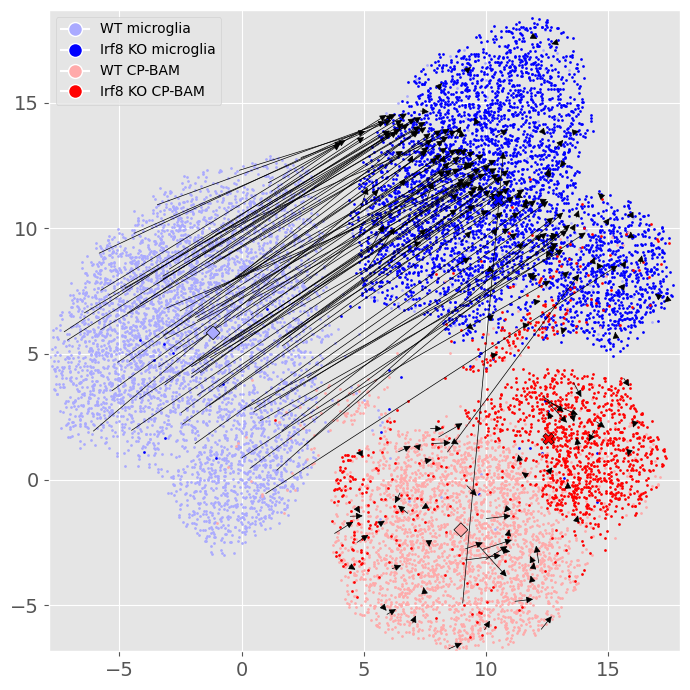

In [13]:
obs = full_dataset.obs.copy()
c = obs.cell_type
discrete_colors = dict( zip( c, c.cat.codes) )
obs[["x", "y"]] = mu_umap
cell_type_means = obs.groupby(["genotype", "cell_type"])[["x","y"]].mean()

cmap_colors = take_cmap_colors(truncate_colormap("bwr", 0, 1), 4)
adjusted_cmap_colors = [cmap_colors[1], cmap_colors[0], cmap_colors[2], cmap_colors[3]]

cell_types = c.value_counts().index.astype("str").values
cell_type_to_color = {cell_type: color for cell_type, color in zip(cell_types, adjusted_cmap_colors)}

fig, ax = plt.subplots(1,1, figsize=(7,7))

for cell_type in cell_types:
    mask = full_dataset.obs['cell_type'].values == cell_type
    plt.scatter(mu_umap[mask,0], mu_umap[mask,1], c=[cell_type_to_color[cell_type]], s=2, label=cell_type)
scatters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in cell_type_to_color.values()]
plt.legend(scatters, cell_types)

mags = np.linalg.norm(z2_umap - z_umap, axis=1)
for i in range(z2_umap.shape[0]):
    # ax.annotate(text='', xy=(z2_umap[i,0], z2_umap[i,1]), xytext=(z_umap[i,0],z_umap[i,1]), arrowprops=dict(arrowstyle='->', color="k", lw=1.45))
    ax.annotate(text='', xy=(z2_umap[i,0], z2_umap[i,1]), xytext=(z_umap[i,0],z_umap[i,1]), arrowprops=dict(arrowstyle='-|>', color="k"))
plt.xlim(1.02*np.percentile(mu_umap[:,0], 0.01), 1.02*np.percentile(mu_umap[:,0], 99.99))
plt.ylim(1.02*np.percentile(mu_umap[:,1], 0.01), 1.02*np.percentile(mu_umap[:,1], 99.99))
plt.xlabel("") # latent z₁
plt.ylabel("") # latent z₂
ax.tick_params(axis='both', which='major', labelsize=14)

hifplus = cell_type_means.loc['WT'].dropna()
hifminus = cell_type_means.loc['KO'].dropna()
plt.scatter(hifplus["x"], hifplus["y"], s=50, c=hifplus.index.astype("str").map(cell_type_to_color), marker="D", edgecolors="black", zorder=np.inf)
plt.scatter(hifminus["x"], hifminus["y"], s=65, c=hifminus.index.astype("str").map(cell_type_to_color), marker="X", edgecolors="black", zorder=np.inf)

# ax.set_aspect(1)
plt.tight_layout()
# plt.savefig(f"data/cko_32d_umap_0border.pdf")
# plt.savefig(f"data/cko_32d_umap_0border.png")
plt.show()

In [14]:
# TRAIN N_ITER MODELS
compute_ari = True
n_iter = 5

train_results = []
test_results = []
for i in range(n_iter):
    # init model and train
    model_params = {"input_dim": next(iter(train_loader))[1].shape[-1], "latent_dim": 32, "scaling_type": "mean"}
    vae = NBVAE(**model_params).to(dev)
    vae_opt = optim.Adam(vae.parameters(), lr=1.2e-3)
    vae, vae_loss_hist = train_nbvae(vae, vae_opt, train_loader, val_loader, 1000, beta=1, warmup_epochs=10, patience=15, dev=dev)
    vae.eval()

    print("\nTRAIN METRICS-------")
    _, _, train_metrics = evaluate_dataset(full_dataset.data[train_indices], full_dataset.log_data[train_indices], 
                                           full_dataset.data_mean[train_indices], vae, "mousebrain", compute_ari, 
                                           ari_ks=np.arange(2, 6, 1), obs=full_dataset.obs.iloc[train_indices])
    print("\nTEST METRICS-------")
    _, _, test_metrics  = evaluate_dataset(full_dataset.data[test_indices], full_dataset.log_data[test_indices],
                                           full_dataset.data_mean[test_indices], vae, "mousebrain", compute_ari,
                                           ari_ks=np.arange(2, 6, 1), obs=full_dataset.obs.iloc[test_indices])

    # append to lists with extra n_iter column
    train_results.append({'n_iter': i, **train_metrics})
    test_results.append({'n_iter': i, **test_metrics})

# convert to dataframe
train_df = pd.DataFrame(train_results)
test_df = pd.DataFrame(test_results)

# write dataframes with tamestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
train_df.to_csv(f"data/cko_train_{timestamp}.csv")
test_df.to_csv(f"data/cko_test_{timestamp}.csv")

# Calculate mean and standard deviation for train metrics
train_mean = train_df.drop(columns=["n_iter"]).mean()
train_std = train_df.drop(columns=["n_iter"]).std()
test_mean = test_df.drop(columns=["n_iter"]).mean()
test_std = test_df.drop(columns=["n_iter"]).std()

# Print the results
print("\nTRAIN STATISTICS--------")
for metric in train_mean.index:
    print(f"Mean {metric:>8}: ${train_mean[metric]:.3f} \pm {train_std[metric]:.3f}$")

print("\nTEST STATISTICS--------")
for metric in test_mean.index:
    print(f"Mean {metric:>8}: ${test_mean[metric]:.3f} \pm {test_std[metric]:.3f}$")

Epochs:  16%|▏| 156/1000 [00:41<03:43,  3.78it/s, Loss=1020.5387, Recon=1013.2033, KL=7.3354, Val=1046.8109, Best=104

Early stopping
Best epoch: 141 val loss: 1046.2095727848102

TRAIN METRICS-------



/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.8835192474567286
ari: 0.8835
rmse: 0.1614 mae: 0.2088

TEST METRICS-------


/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.8725883480795185
ari: 0.8726
rmse: 0.1626 mae: 0.2098


Epochs:  13%|▏| 131/1000 [00:34<03:51,  3.75it/s, Loss=1025.7250, Recon=1019.2131, KL=6.5119, Val=1048.7984, Best=104

Early stopping
Best epoch: 116 val loss: 1047.9023734177215

TRAIN METRICS-------



/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.8850851410255441
ari: 0.8851
rmse: 0.1626 mae: 0.2108

TEST METRICS-------


/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.5520339938037643
ari: 0.5520
rmse: 0.1635 mae: 0.2116


Epochs:  13%|▏| 127/1000 [00:33<03:50,  3.79it/s, Loss=1038.8363, Recon=1031.7228, KL=7.1134, Val=1067.3751, Best=106

Early stopping
Best epoch: 112 val loss: 1064.5429193037974

TRAIN METRICS-------



/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.833509507068348
ari: 0.8335
rmse: 0.1703 mae: 0.2158

TEST METRICS-------


/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.7360139846531547
ari: 0.7360
rmse: 0.1713 mae: 0.2166


Epochs:  14%|▏| 139/1000 [00:35<03:41,  3.89it/s, Loss=1021.7918, Recon=1014.5595, KL=7.2322, Val=1049.7072, Best=104

Early stopping
Best epoch: 124 val loss: 1048.3268987341771

TRAIN METRICS-------



/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.8835177636589483
ari: 0.8835
rmse: 0.1626 mae: 0.2109

TEST METRICS-------


/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.8631384787540334
ari: 0.8631
rmse: 0.1637 mae: 0.2117


Epochs:  17%|▏| 171/1000 [00:45<03:38,  3.79it/s, Loss=1019.3241, Recon=1012.1341, KL=7.1901, Val=1047.8169, Best=104

Early stopping
Best epoch: 156 val loss: 1046.0026898734177

TRAIN METRICS-------



/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.8617186184752098
ari: 0.8617
rmse: 0.1617 mae: 0.2096

TEST METRICS-------


/home/fvk220/fvk220/.venv/lib64/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


best k: 2 ari: 0.5220945757283539
ari: 0.5221
rmse: 0.1626 mae: 0.2102

TRAIN STATISTICS--------
Mean     rmse: $0.164 \pm 0.004$
Mean      mae: $0.211 \pm 0.003$
Mean      ari: $0.869 \pm 0.022$

TEST STATISTICS--------
Mean     rmse: $0.165 \pm 0.004$
Mean      mae: $0.212 \pm 0.003$
Mean      ari: $0.709 \pm 0.166$
